In [1]:
import os
from  scipy.optimize import curve_fit
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

Data transcribed from text statements published here: https://www.essen.de/coronavirus

In [2]:
path = os.path.normpath(r"CoronaCases.csv")
df = pd.read_csv(path,index_col='Day',parse_dates=True,infer_datetime_format=True)
df.head()

,Cases,Active,Tests,Deaths,recovered
Day,,,,,
2020-03-02 19:15:00,1,1,50.0,0,0
2020-03-03 20:00:00,2,2,100.0,0,0
2020-03-04 17:30:00,3,3,250.0,0,0
2020-03-06 17:50:00,4,4,300.0,0,0
2020-03-07 16:30:00,6,6,331.0,0,0


In [3]:
base = datetime.datetime(year=2020,month=3,day=1)
numdays = 56
datelist = [base + datetime.timedelta(days=x) for x in range(0,numdays,7)]

In [4]:
def lin_growth(t,m,b):
    t0 = t[0]
    days = [datetime.timedelta.total_seconds(Ti-t0)/(24*3600) for Ti in t]
    days = np.array(days)
    return (m*(days)+b)

In [5]:
# popt,err = curve_fit(lin_growth,df['2020-03-13 00:00':].index,df['2020-03-13 00:00':].Cases)
# popt

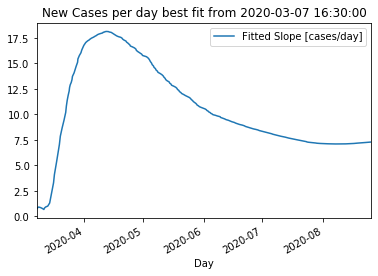

In [6]:
k = []
pd.plotting.register_matplotlib_converters()
start = 4
for i in range(start,len(df.index)):
    a,err = curve_fit(lin_growth,df.index[0:i],df.Cases[0:i])
    df.loc[df.index[i],'Fit'] = a[0]
    df.loc[df.index[i],'error'] = err[0][0]**.5
    

df[start:].plot(y='Fit',use_index=True,label='Fitted Slope [cases/day]')
plt.gca().set_title(f'New Cases per day best fit from {df.index[start]}')
plt.gcf().autofmt_xdate()

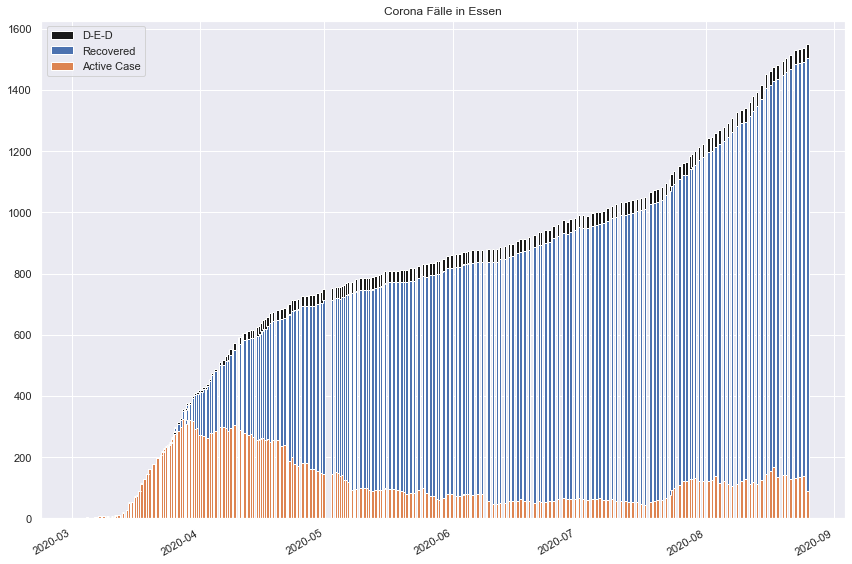

In [7]:
sns.set()
f,axes = plt.subplots(1,1,figsize=(12,8),sharex=True)
ax1 = axes

p2 = ax1.bar(x=df.index,height=df['Active'],width=.6,color='C1')
p3 = ax1.bar(x=df.index,height=df['recovered'],bottom=df['Active'],width=.6,color='C0')
p1 = ax1.bar(x=df.index,height=df['Deaths'],bottom=(df['recovered']+df['Active']),width=.6,color='k')


pd.plotting.register_matplotlib_converters()

ax1.legend((p1[0], p3[0], p2[0],), ('D-E-D', 'Recovered','Active Case'))

f.autofmt_xdate()
_ = ax1.set_title('Corona Fälle in Essen')

df['NewCases'] = df['Cases'].diff()
df['NewRecoveries'] = df['recovered'].diff()
daily = df[['NewCases','NewRecoveries']].resample('D').sum()

ax1.vlines
f.autofmt_xdate()
f.tight_layout()


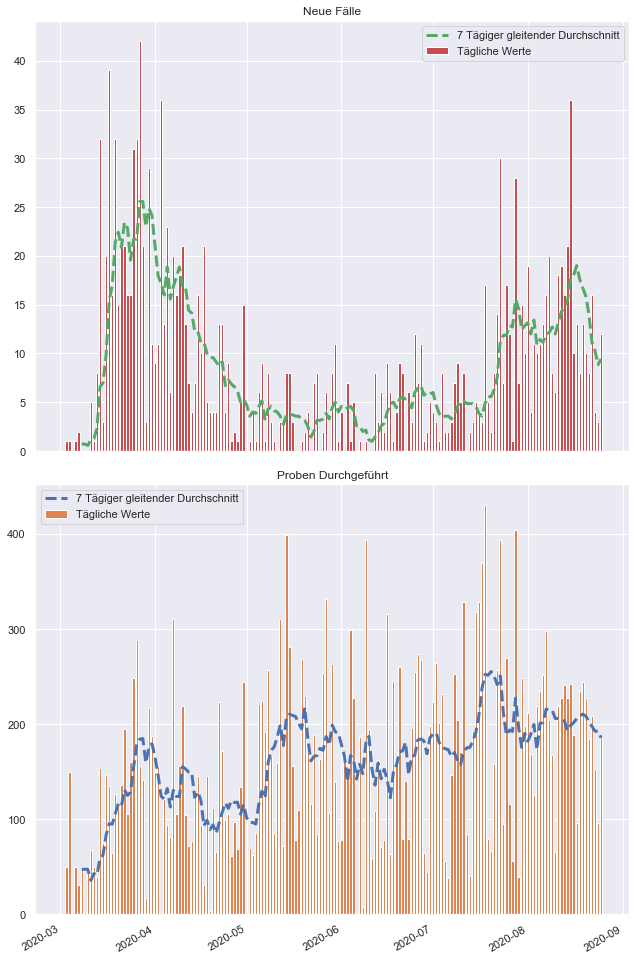

In [16]:
avg_period = 7
window_cent = False


df['NewCases'] = df['Cases'].diff()
df['NewRecoveries'] = df['recovered'].diff()
df['NewTests'] = df['Tests'].diff()
df['pct'] = df['NewCases']/df['NewTests']
daily = df[['NewCases','NewRecoveries','NewTests','pct']].resample('D').sum()

fig,ax = plt.subplots(2,1,figsize=(9,13.5),sharex=True)
ax[1].set_title('Proben Durchgeführt')
ax[1].plot(daily.index,daily.NewTests.rolling(window=avg_period,center=window_cent).mean(),label=f'{avg_period} Tägiger gleitender Durchschnitt',color='C0',linestyle='--',linewidth=3)
ax[1].bar(x=daily.index,height=daily.NewTests,width=.75,label='Tägliche Werte',color='C1')
ax[1].legend()

ax[0].set_title('Neue Fälle')
ax[0].plot(daily.index,daily.NewCases.rolling(window=avg_period,center=window_cent).mean(),color='C2',label=f'{avg_period} Tägiger gleitender Durchschnitt',linestyle='--',linewidth=3)
ax[0].bar(x=daily.index,height=daily.NewCases,width=.75,color='C3',label='Tägliche Werte')
ax[0].legend()

fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("C:/Users/J33290/Desktop/proben.png",dpi=300,bbox='tight')

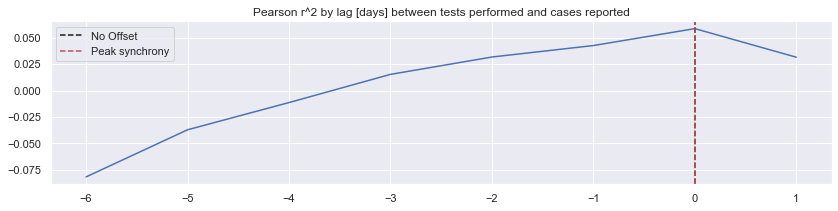

In [9]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    
d1 = daily.NewCases.rolling(window=avg_period).mean()
d2 = daily.NewTests.rolling(window=avg_period).mean()
offsets = [x for x in range(-6,2)]
win = 8

rs = [crosscorr(d1,d2, lag) for lag in offsets]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(range(-int(3*win/4),int(win/4)),rs)
ax.axvline(0,color='k',linestyle='--',label='No Offset')
ax.axvline(offsets[np.argmax(rs)],color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Pearson r^2 by lag [days] between tests performed and cases reported')
plt.legend()
plt.savefig("C:/Users/J33290/Desktop/Synchrony.png",dpi=300,bbox='tight')

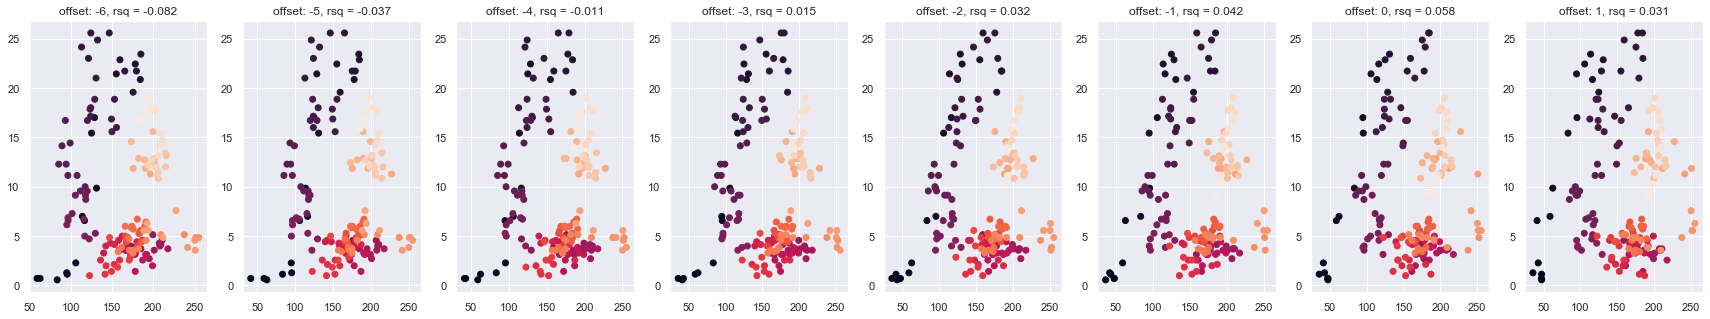

In [10]:
f,ax= plt.subplots(1,len(offsets),figsize=(30,5))
for i in range(len(offsets)):
    ax[i].scatter(daily.NewTests.shift(offsets[i]).rolling(window=avg_period).mean(),daily.NewCases.rolling(window=avg_period).mean(),c=daily.index)
    ax[i].set_title(f'offset: {offsets[i]}, rsq = {rs[i]:.3f}')


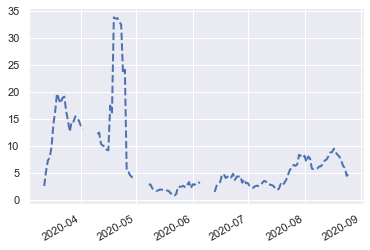

In [11]:
daily['pct']=daily.NewCases/daily.NewTests
plt.plot(daily.index,daily.pct.rolling(window=avg_period).mean()*100,color='C0',linestyle='--',linewidth=2)
plt.gcf().autofmt_xdate()

In [12]:
daily.groupby(by=daily.index.day_name()).mean()

,NewCases,NewRecoveries,NewTests,pct
Day,,,,
Friday,10.680000,7.680000,165.640000,inf
Monday,5.000000,6.538462,88.076923,0.049306
Saturday,12.200000,7.000000,179.000000,0.073520
Sunday,5.480000,1.080000,94.800000,0.110335
Thursday,10.360000,11.000000,206.920000,0.053406
Tuesday,8.538462,14.500000,197.307692,0.047076
Wednesday,9.120000,7.960000,181.640000,0.064782


In [13]:
df['err'] = df['Cases']-df['Active']-df['Deaths']-df['recovered']

In [14]:
df[df['err']!=0]

,Cases,Active,Tests,Deaths,recovered,Fit,error,NewCases,NewRecoveries,NewTests,pct,err
Day,,,,,,,,,,,,
2020-05-25 16:10:00,832,83,11236.0,40,707,11.460085,0.320149,0.0,10.0,144.0,0.000000,2
2020-06-04 15:45:00,872,79,13099.0,41,754,10.110201,0.297368,0.0,2.0,199.0,0.000000,-2
2020-06-28 17:30:00,975,62,16991.0,41,867,8.476185,0.258902,1.0,0.0,65.0,0.015385,5
2020-07-01 09:50:00,986,66,17457.0,41,886,8.316077,0.252842,4.0,8.0,223.0,0.017937,-7
2020-07-02 09:50:00,989,63,17721.0,41,886,8.264217,0.250834,3.0,0.0,264.0,0.011364,-1
2020-07-03 13:00:00,990,61,17922.0,41,887,8.212581,0.248854,1.0,1.0,201.0,0.004975,1
2020-07-08 09:20:00,1012,60,18648.0,41,912,7.958345,0.239291,7.0,8.0,253.0,0.027668,-1
2020-07-23 09:40:00,1100,76,21906.0,41,993,7.335339,0.210168,3.0,4.0,228.0,0.013158,-10
